In [2]:
import os
import shutil
from glob import glob
from pathlib import Path, PurePath
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from PIL import Image
import cv2

from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
from torchvision import datasets, models, transforms

In [3]:
from torchvision import transforms

class TrafficSignDataset(Dataset):
    '''Classe qui charge les données'''

    def __init__(self, img_dir, labels_dir, transform=None):
        '''initialisation de la classe'''
        
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.labels = self.load_labels()
        self.classes = ['ceder', 'danger', 'frouge', 'forange', 'fvert', 'interdiction', 'obligation', 'stop']

        
    def load_img(self, img_path):
        '''Charge une image à partir du chemin du fichier de l'image'''

        img = Image.open(img_path).convert('RGB')
        #img = cv2.imread(img_path)
        return img

        
    def load_labels(self):
        '''Charge pour chaque panneaux ses coordonnees de boites englobante et le chemin de l'image'''

        labels = []

        for filename in os.listdir(self.labels_dir):
            if filename.endswith('.csv'):
                with open(os.path.join(self.labels_dir, filename), 'r') as f:
                    lines = f.readlines()
                    list_bbox = []
                    list_label = []
                    for line in lines:
                        parts = line.strip().split(',')
                        if len(parts) == 5:
                            if parts[4] != 'ff':
                                # y_min, x_min, y_max, x_max
                                labels.append({
                                    'file_name': os.path.join(self.img_dir, filename[:-4] + '.jpg'),  # Adapter l'extension d'image si nécessaire
                                    'bbox': [int(parts[0]), int(parts[1]), int(parts[2]), int(parts[3])],  # y_min, x_min, y_max, x_max
                                    'label': parts[4]
                                })                        
        return labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        '''renvoie l'image, le label et la boite'''

        label = self.labels[index]
        img_path = label['file_name']
        img = self.load_img(img_path)
        
        original_width, original_height = img.size
        # Calcul des facteurs d'échelle
        scale_x = 224 / original_width
        scale_y = 224 / original_height

        
        bbox = label['bbox']
        #Redimensionner les coordonnées des boîtes englobantes
        x_min = bbox[0] * scale_x
        y_min = bbox[1] * scale_y
        x_max = bbox[2] * scale_x
        y_max = bbox[3] * scale_y

        bbox = [x_min, y_min, x_max, y_max]
        
        while True:
            label_str = label['label']
            if label_str != 'ff':
                    break
        label_list = [0 for _ in range(len(self.classes))]
        label_int = self.classes.index(label_str)
        label_list[label_int] = 1
        #print(label_list)
        
        bbox = torch.tensor(bbox, dtype=torch.float32)
        #label_int = torch.tensor([label_int], dtype=torch.int64)
        label_list = torch.tensor(label_list, dtype=torch.int64)

        if self.transform:
            img = self.transform(img)
        
        
        return (img, label_list, bbox)
 
# Taille de l'image et du Batch
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16

# Transformation de l'image
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])

# Chemin des images et labels
img_dir = os.path.join('/kaggle', 'input', 'sy32-dataset', 'dataset', 'train', 'images')
label_dir = os.path.join('/kaggle', 'input', 'sy32-dataset', 'dataset', 'train', 'labels')

dataset = TrafficSignDataset(img_dir, label_dir, transform)

# Test sur une image
img2 = dataset.__getitem__(2)
print(f"Image shape : {img2[0].shape}, Label shape : {img2[1].shape}, Bbox shape : {img2[2].shape}")
print("Label : ", img2[1])
print("Bbox : ", img2[2])


Image shape : torch.Size([3, 224, 224]), Label shape : torch.Size([8]), Bbox shape : torch.Size([4])
Label :  tensor([0, 0, 0, 0, 0, 1, 0, 0])
Bbox :  tensor([186.1440, 114.5861, 199.3600, 134.8774])


In [4]:
# chargement du Dasatet
trainset = TrafficSignDataset(img_dir, label_dir, transform)
train_data_loader = torch.utils.data.DataLoader(trainset, BATCH_SIZE, shuffle=True)
first_batch = next(iter(train_data_loader))

# affichager du premier batch
print(first_batch[0].shape, len(first_batch[1]), len(first_batch[2]))
print(first_batch[0].shape, first_batch[1].shape, first_batch[2].shape)

torch.Size([16, 3, 224, 224]) 16 16
torch.Size([16, 3, 224, 224]) torch.Size([16, 8]) torch.Size([16, 4])


In [8]:
class ObjectDetection(nn.Module):
    '''Classe pour architecture du modèle'''
    
    def __init__(self, in_channels=3, out_channels_cnn=8, bboxes=4):        
        super().__init__()
        hidden_channel1 = 32
        hidden_channel2 = 64
        hidden_channel3 = 128
        kernel_size = 3
        stride = 1
        padding = 1
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channel1,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv2 = nn.Conv2d(in_channels=hidden_channel1,
                               out_channels=hidden_channel2,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv3 = nn.Conv2d(in_channels=hidden_channel2,
                               out_channels=hidden_channel2,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv4 = nn.Conv2d(in_channels=hidden_channel2,
                               out_channels=hidden_channel3,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv5 = nn.Conv2d(in_channels=hidden_channel3,
                               out_channels=hidden_channel3,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channel1)
        self.batchnorm2 = nn.BatchNorm2d(hidden_channel2)
        self.batchnorm3 = nn.BatchNorm2d(hidden_channel3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc = nn.Flatten()
        self.cnn_layer = nn.Linear(7*7*128, out_channels_cnn)
        self.regressor = nn.Linear(7*7*128, bboxes)
    
    def cnn_layers(self, x):
        x = self.relu(x)
        x = self.maxpool(x)
        return x
    
    def feature_extractor(self, x):

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.cnn_layers(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.cnn_layers(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.cnn_layers(x)
        
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.cnn_layers(x)
        
        x = self.conv5(x)
        x = self.batchnorm3(x)
        x = self.cnn_layers(x)
        
        x = self.fc(x)
        return x
    
    def forward(self, x):
        x = self.feature_extractor(x)
        classifier_op = self.cnn_layer(x)
        regressor_op = self.regressor(x)
        return (regressor_op, classifier_op)

In [9]:
# chargement du modèle
model = ObjectDetection(in_channels=3, out_channels_cnn=8, bboxes=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device :', device)

# affichage du modèle
model = model.to(device)
print(model)

Device : cpu
ObjectDetection(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc): Flatten(start_dim=1, end_dim=-1)
  (cnn_layer): Linear(in_features=6272, out_features=8, bias=True)
  (regressor): Linear(in_features=6272, out_features=4, bias=True)
)


In [9]:
import torch.optim as optim
from tqdm import tqdm

# nombre d'epochs
EPOCHS = 20
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

# Définition des fonctions de perte
classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.SmoothL1Loss()

# Définition de l'optimiseur 
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Ordonnanceur de taux d'apprentissage
scheduler = optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

for epoch in tqdm(range(EPOCHS)):
    correct = 0
    iterations = 0
    iter_loss = 0
    model.train()
    for i, (images, labels, bbox) in enumerate(train_data_loader):
    
        images = images.to(device)
        labels = labels.to(device)
        bbox = bbox.to(device)

        # boite et label predit
        regressor, classifier = model(images)
        
        _, predicted = torch.max(classifier, 1) 
        predicted_bbox = bbox + regressor 
    
        labels_indices = torch.argmax(labels, dim=1)
        
        # Conversion en type Long
        labels = labels.to(device).squeeze(1).long()  
        
        # calcul des pertes
        clf_loss = classification_loss_fn(classifier, labels_indices)
        reg_loss = bbox_loss_fn(predicted_bbox, bbox)
        total_loss = (clf_loss + reg_loss).clone().detach().requires_grad_(True)

        opt.zero_grad()
        total_loss.backward()
        opt.step()
                
        iter_loss += total_loss.item()
        correct += (predicted == labels_indices).sum().item()
        iterations += 1
        
        if i%10 == 0:
            print(f"Epoch [{epoch + 1} / {EPOCHS}], i: {i}, clf_loss: {clf_loss}, reg_loss: {reg_loss}")
        
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct / len(trainset)))
    print(f"Epoch [{epoch + 1} / {EPOCHS}], Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_accuracy[-1]:.3f}")
    
    # Ordonnanceur de taux d'apprentissage
    scheduler.step()

    torch.save(model.state_dict(), "model_deep_learning.pth")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1 / 20], i: 0, clf_loss: 2.7186245918273926, reg_loss: 0.17441953718662262
Epoch [1 / 20], i: 10, clf_loss: 2.142075538635254, reg_loss: 0.1638856679201126
Epoch [1 / 20], i: 20, clf_loss: 2.008613348007202, reg_loss: 0.1767154484987259
Epoch [1 / 20], i: 30, clf_loss: 2.1117637157440186, reg_loss: 0.14930236339569092
Epoch [1 / 20], i: 40, clf_loss: 2.260305166244507, reg_loss: 0.1582781970500946
Epoch [1 / 20], i: 50, clf_loss: 2.2732458114624023, reg_loss: 0.153385192155838
Epoch [1 / 20], i: 60, clf_loss: 2.3604180812835693, reg_loss: 0.14672864973545074


  5%|▌         | 1/20 [01:04<20:16, 64.01s/it]

Epoch [1 / 20], i: 70, clf_loss: 2.531541585922241, reg_loss: 0.1357164829969406
Epoch [1 / 20], Training Loss: 2.444, Training Accuracy: 12.081
Epoch [2 / 20], i: 0, clf_loss: 2.5246493816375732, reg_loss: 0.146140918135643
Epoch [2 / 20], i: 10, clf_loss: 2.5334506034851074, reg_loss: 0.132475346326828
Epoch [2 / 20], i: 20, clf_loss: 2.4022889137268066, reg_loss: 0.17954736948013306
Epoch [2 / 20], i: 30, clf_loss: 2.373473882675171, reg_loss: 0.16371142864227295
Epoch [2 / 20], i: 40, clf_loss: 2.1283774375915527, reg_loss: 0.20061372220516205
Epoch [2 / 20], i: 50, clf_loss: 2.2936787605285645, reg_loss: 0.18468260765075684
Epoch [2 / 20], i: 60, clf_loss: 2.471282720565796, reg_loss: 0.14964352548122406


 10%|█         | 2/20 [02:06<18:52, 62.92s/it]

Epoch [2 / 20], i: 70, clf_loss: 2.5349605083465576, reg_loss: 0.168343186378479
Epoch [2 / 20], Training Loss: 2.445, Training Accuracy: 12.875
Epoch [3 / 20], i: 0, clf_loss: 2.365370988845825, reg_loss: 0.15440106391906738
Epoch [3 / 20], i: 10, clf_loss: 2.2699666023254395, reg_loss: 0.18549077212810516
Epoch [3 / 20], i: 20, clf_loss: 2.225682497024536, reg_loss: 0.1281503289937973
Epoch [3 / 20], i: 30, clf_loss: 2.5743918418884277, reg_loss: 0.16767185926437378
Epoch [3 / 20], i: 40, clf_loss: 2.6460318565368652, reg_loss: 0.14465220272541046
Epoch [3 / 20], i: 50, clf_loss: 2.440155029296875, reg_loss: 0.15048208832740784
Epoch [3 / 20], i: 60, clf_loss: 2.0129077434539795, reg_loss: 0.20105208456516266


 15%|█▌        | 3/20 [03:08<17:43, 62.56s/it]

Epoch [3 / 20], i: 70, clf_loss: 2.1434485912323, reg_loss: 0.2515469491481781
Epoch [3 / 20], Training Loss: 2.443, Training Accuracy: 12.346
Epoch [4 / 20], i: 0, clf_loss: 2.283202886581421, reg_loss: 0.1441992223262787
Epoch [4 / 20], i: 10, clf_loss: 2.112776041030884, reg_loss: 0.1631222516298294
Epoch [4 / 20], i: 20, clf_loss: 2.121887683868408, reg_loss: 0.1993899643421173
Epoch [4 / 20], i: 30, clf_loss: 2.1584463119506836, reg_loss: 0.17923961579799652
Epoch [4 / 20], i: 40, clf_loss: 2.1115121841430664, reg_loss: 0.14940378069877625
Epoch [4 / 20], i: 50, clf_loss: 2.25919508934021, reg_loss: 0.169460266828537
Epoch [4 / 20], i: 60, clf_loss: 2.347918748855591, reg_loss: 0.17057213187217712


 20%|██        | 4/20 [04:09<16:34, 62.16s/it]

Epoch [4 / 20], i: 70, clf_loss: 2.0463836193084717, reg_loss: 0.15665696561336517
Epoch [4 / 20], Training Loss: 2.448, Training Accuracy: 11.993
Epoch [5 / 20], i: 0, clf_loss: 2.306647539138794, reg_loss: 0.1807321310043335
Epoch [5 / 20], i: 10, clf_loss: 2.0607566833496094, reg_loss: 0.15631252527236938
Epoch [5 / 20], i: 20, clf_loss: 2.1819918155670166, reg_loss: 0.22511406242847443
Epoch [5 / 20], i: 30, clf_loss: 2.7970523834228516, reg_loss: 0.19409534335136414
Epoch [5 / 20], i: 40, clf_loss: 2.494110584259033, reg_loss: 0.189161479473114
Epoch [5 / 20], i: 50, clf_loss: 2.461447238922119, reg_loss: 0.16085533797740936
Epoch [5 / 20], i: 60, clf_loss: 2.2961111068725586, reg_loss: 0.1734420210123062


 25%|██▌       | 5/20 [05:11<15:29, 61.96s/it]

Epoch [5 / 20], i: 70, clf_loss: 2.3774666786193848, reg_loss: 0.16959106922149658
Epoch [5 / 20], Training Loss: 2.441, Training Accuracy: 12.169
Epoch [6 / 20], i: 0, clf_loss: 2.4660301208496094, reg_loss: 0.2009734958410263
Epoch [6 / 20], i: 10, clf_loss: 2.417236804962158, reg_loss: 0.17086321115493774
Epoch [6 / 20], i: 20, clf_loss: 2.2730655670166016, reg_loss: 0.14680081605911255
Epoch [6 / 20], i: 30, clf_loss: 2.2071666717529297, reg_loss: 0.18760251998901367
Epoch [6 / 20], i: 40, clf_loss: 2.3982226848602295, reg_loss: 0.1994088590145111
Epoch [6 / 20], i: 50, clf_loss: 2.336221218109131, reg_loss: 0.18418166041374207
Epoch [6 / 20], i: 60, clf_loss: 2.2969961166381836, reg_loss: 0.141071617603302


 30%|███       | 6/20 [06:13<14:28, 62.00s/it]

Epoch [6 / 20], i: 70, clf_loss: 2.326692819595337, reg_loss: 0.1651921421289444
Epoch [6 / 20], Training Loss: 2.439, Training Accuracy: 12.346
Epoch [7 / 20], i: 0, clf_loss: 2.5367555618286133, reg_loss: 0.16929715871810913
Epoch [7 / 20], i: 10, clf_loss: 2.2519655227661133, reg_loss: 0.174865260720253
Epoch [7 / 20], i: 20, clf_loss: 2.1591238975524902, reg_loss: 0.15826882421970367
Epoch [7 / 20], i: 30, clf_loss: 2.242330551147461, reg_loss: 0.1945914477109909
Epoch [7 / 20], i: 40, clf_loss: 2.2948248386383057, reg_loss: 0.15631788969039917
Epoch [7 / 20], i: 50, clf_loss: 2.159816265106201, reg_loss: 0.17039591073989868
Epoch [7 / 20], i: 60, clf_loss: 2.3169591426849365, reg_loss: 0.1518975794315338


 35%|███▌      | 7/20 [07:17<13:32, 62.50s/it]

Epoch [7 / 20], i: 70, clf_loss: 2.3137640953063965, reg_loss: 0.13804513216018677
Epoch [7 / 20], Training Loss: 2.444, Training Accuracy: 12.081
Epoch [8 / 20], i: 0, clf_loss: 2.5416088104248047, reg_loss: 0.19011937081813812
Epoch [8 / 20], i: 10, clf_loss: 2.3268659114837646, reg_loss: 0.14710421860218048
Epoch [8 / 20], i: 20, clf_loss: 2.5185704231262207, reg_loss: 0.21205633878707886
Epoch [8 / 20], i: 30, clf_loss: 2.263808488845825, reg_loss: 0.1778462678194046
Epoch [8 / 20], i: 40, clf_loss: 2.208240270614624, reg_loss: 0.20346519351005554
Epoch [8 / 20], i: 50, clf_loss: 2.4716501235961914, reg_loss: 0.12882287800312042
Epoch [8 / 20], i: 60, clf_loss: 2.1734778881073, reg_loss: 0.16584639251232147


 40%|████      | 8/20 [08:20<12:33, 62.77s/it]

Epoch [8 / 20], i: 70, clf_loss: 2.107912302017212, reg_loss: 0.17162255942821503
Epoch [8 / 20], Training Loss: 2.441, Training Accuracy: 12.434
Epoch [9 / 20], i: 0, clf_loss: 2.1436986923217773, reg_loss: 0.19277019798755646
Epoch [9 / 20], i: 10, clf_loss: 2.389659881591797, reg_loss: 0.1810804307460785
Epoch [9 / 20], i: 20, clf_loss: 2.4412946701049805, reg_loss: 0.17896543443202972
Epoch [9 / 20], i: 30, clf_loss: 2.4421873092651367, reg_loss: 0.1746714562177658
Epoch [9 / 20], i: 40, clf_loss: 2.278822422027588, reg_loss: 0.18914590775966644
Epoch [9 / 20], i: 50, clf_loss: 2.0892887115478516, reg_loss: 0.1759665608406067
Epoch [9 / 20], i: 60, clf_loss: 2.10422945022583, reg_loss: 0.16175632178783417


 45%|████▌     | 9/20 [09:22<11:27, 62.54s/it]

Epoch [9 / 20], i: 70, clf_loss: 2.2847201824188232, reg_loss: 0.11684192717075348
Epoch [9 / 20], Training Loss: 2.441, Training Accuracy: 12.346
Epoch [10 / 20], i: 0, clf_loss: 2.3426222801208496, reg_loss: 0.17368420958518982
Epoch [10 / 20], i: 10, clf_loss: 2.3172473907470703, reg_loss: 0.16689124703407288
Epoch [10 / 20], i: 20, clf_loss: 2.53161358833313, reg_loss: 0.14764326810836792
Epoch [10 / 20], i: 30, clf_loss: 1.9352529048919678, reg_loss: 0.1705373376607895
Epoch [10 / 20], i: 40, clf_loss: 2.4870195388793945, reg_loss: 0.20264284312725067
Epoch [10 / 20], i: 50, clf_loss: 2.228849411010742, reg_loss: 0.18865075707435608
Epoch [10 / 20], i: 60, clf_loss: 2.486436605453491, reg_loss: 0.1850009262561798


 50%|█████     | 10/20 [10:24<10:23, 62.34s/it]

Epoch [10 / 20], i: 70, clf_loss: 2.086005449295044, reg_loss: 0.21223850548267365
Epoch [10 / 20], Training Loss: 2.441, Training Accuracy: 11.817
Epoch [11 / 20], i: 0, clf_loss: 2.0195140838623047, reg_loss: 0.15903685986995697
Epoch [11 / 20], i: 10, clf_loss: 2.305295705795288, reg_loss: 0.1901131570339203
Epoch [11 / 20], i: 20, clf_loss: 2.0205774307250977, reg_loss: 0.18321189284324646
Epoch [11 / 20], i: 30, clf_loss: 2.3188695907592773, reg_loss: 0.17748191952705383
Epoch [11 / 20], i: 40, clf_loss: 2.2184200286865234, reg_loss: 0.1811649054288864
Epoch [11 / 20], i: 50, clf_loss: 2.0446271896362305, reg_loss: 0.16004078090190887
Epoch [11 / 20], i: 60, clf_loss: 2.215151786804199, reg_loss: 0.15989208221435547


 55%|█████▌    | 11/20 [11:26<09:21, 62.43s/it]

Epoch [11 / 20], i: 70, clf_loss: 2.688735246658325, reg_loss: 0.18098090589046478
Epoch [11 / 20], Training Loss: 2.438, Training Accuracy: 11.993
Epoch [12 / 20], i: 0, clf_loss: 2.2337894439697266, reg_loss: 0.1492094248533249
Epoch [12 / 20], i: 10, clf_loss: 2.3828396797180176, reg_loss: 0.19369760155677795
Epoch [12 / 20], i: 20, clf_loss: 2.1228761672973633, reg_loss: 0.18203945457935333
Epoch [12 / 20], i: 30, clf_loss: 2.2892074584960938, reg_loss: 0.16033720970153809
Epoch [12 / 20], i: 40, clf_loss: 2.1256542205810547, reg_loss: 0.2169911414384842
Epoch [12 / 20], i: 50, clf_loss: 2.490126371383667, reg_loss: 0.12015186250209808
Epoch [12 / 20], i: 60, clf_loss: 2.3227715492248535, reg_loss: 0.15827903151512146


 60%|██████    | 12/20 [12:28<08:18, 62.27s/it]

Epoch [12 / 20], i: 70, clf_loss: 2.2473201751708984, reg_loss: 0.160303995013237
Epoch [12 / 20], Training Loss: 2.438, Training Accuracy: 12.522
Epoch [13 / 20], i: 0, clf_loss: 2.014324426651001, reg_loss: 0.17650461196899414
Epoch [13 / 20], i: 10, clf_loss: 2.171884536743164, reg_loss: 0.1934848427772522
Epoch [13 / 20], i: 20, clf_loss: 2.533271551132202, reg_loss: 0.19886331260204315
Epoch [13 / 20], i: 30, clf_loss: 2.3904168605804443, reg_loss: 0.15069431066513062
Epoch [13 / 20], i: 40, clf_loss: 2.784414768218994, reg_loss: 0.17255213856697083
Epoch [13 / 20], i: 50, clf_loss: 2.3731162548065186, reg_loss: 0.18047036230564117
Epoch [13 / 20], i: 60, clf_loss: 2.413914918899536, reg_loss: 0.13556945323944092


 65%|██████▌   | 13/20 [13:31<07:15, 62.24s/it]

Epoch [13 / 20], i: 70, clf_loss: 2.437927484512329, reg_loss: 0.17496545612812042
Epoch [13 / 20], Training Loss: 2.439, Training Accuracy: 11.993
Epoch [14 / 20], i: 0, clf_loss: 2.4216697216033936, reg_loss: 0.14074943959712982
Epoch [14 / 20], i: 10, clf_loss: 2.0799779891967773, reg_loss: 0.2400118112564087
Epoch [14 / 20], i: 20, clf_loss: 2.122400999069214, reg_loss: 0.19154241681098938
Epoch [14 / 20], i: 30, clf_loss: 2.3339273929595947, reg_loss: 0.18433648347854614
Epoch [14 / 20], i: 40, clf_loss: 2.0679407119750977, reg_loss: 0.18835678696632385
Epoch [14 / 20], i: 50, clf_loss: 2.567004919052124, reg_loss: 0.15178290009498596
Epoch [14 / 20], i: 60, clf_loss: 2.104370355606079, reg_loss: 0.18093110620975494


 70%|███████   | 14/20 [14:34<06:15, 62.51s/it]

Epoch [14 / 20], i: 70, clf_loss: 2.40087890625, reg_loss: 0.18575666844844818
Epoch [14 / 20], Training Loss: 2.446, Training Accuracy: 12.346
Epoch [15 / 20], i: 0, clf_loss: 2.2000372409820557, reg_loss: 0.19776754081249237
Epoch [15 / 20], i: 10, clf_loss: 2.177414894104004, reg_loss: 0.1615474969148636
Epoch [15 / 20], i: 20, clf_loss: 2.292757511138916, reg_loss: 0.196886345744133
Epoch [15 / 20], i: 30, clf_loss: 2.057232618331909, reg_loss: 0.15617218613624573
Epoch [15 / 20], i: 40, clf_loss: 2.051337242126465, reg_loss: 0.165782630443573
Epoch [15 / 20], i: 50, clf_loss: 2.27170729637146, reg_loss: 0.16496199369430542
Epoch [15 / 20], i: 60, clf_loss: 2.1721670627593994, reg_loss: 0.1786578744649887


 75%|███████▌  | 15/20 [15:36<05:12, 62.47s/it]

Epoch [15 / 20], i: 70, clf_loss: 2.5493547916412354, reg_loss: 0.18872959911823273
Epoch [15 / 20], Training Loss: 2.440, Training Accuracy: 11.993
Epoch [16 / 20], i: 0, clf_loss: 2.3654625415802, reg_loss: 0.15036344528198242
Epoch [16 / 20], i: 10, clf_loss: 2.337128162384033, reg_loss: 0.1916695237159729
Epoch [16 / 20], i: 20, clf_loss: 2.246595859527588, reg_loss: 0.20503343641757965
Epoch [16 / 20], i: 30, clf_loss: 2.448028802871704, reg_loss: 0.210749551653862
Epoch [16 / 20], i: 40, clf_loss: 2.3888463973999023, reg_loss: 0.15307454764842987
Epoch [16 / 20], i: 50, clf_loss: 2.391676902770996, reg_loss: 0.18059422075748444
Epoch [16 / 20], i: 60, clf_loss: 2.2973482608795166, reg_loss: 0.1608888953924179


 80%|████████  | 16/20 [16:38<04:09, 62.30s/it]

Epoch [16 / 20], i: 70, clf_loss: 2.527362823486328, reg_loss: 0.14635606110095978
Epoch [16 / 20], Training Loss: 2.438, Training Accuracy: 11.905
Epoch [17 / 20], i: 0, clf_loss: 2.4801645278930664, reg_loss: 0.18258462846279144
Epoch [17 / 20], i: 10, clf_loss: 2.160370349884033, reg_loss: 0.18687492609024048
Epoch [17 / 20], i: 20, clf_loss: 2.0279860496520996, reg_loss: 0.18370488286018372
Epoch [17 / 20], i: 30, clf_loss: 2.2029364109039307, reg_loss: 0.15269474685192108
Epoch [17 / 20], i: 40, clf_loss: 2.3921802043914795, reg_loss: 0.1788220852613449
Epoch [17 / 20], i: 50, clf_loss: 2.573577404022217, reg_loss: 0.17497988045215607
Epoch [17 / 20], i: 60, clf_loss: 2.102686643600464, reg_loss: 0.21840687096118927


 85%|████████▌ | 17/20 [17:40<03:06, 62.25s/it]

Epoch [17 / 20], i: 70, clf_loss: 2.2719180583953857, reg_loss: 0.12439893186092377
Epoch [17 / 20], Training Loss: 2.444, Training Accuracy: 12.257
Epoch [18 / 20], i: 0, clf_loss: 2.3629188537597656, reg_loss: 0.18721412122249603
Epoch [18 / 20], i: 10, clf_loss: 2.077099561691284, reg_loss: 0.1844039261341095
Epoch [18 / 20], i: 20, clf_loss: 2.3131392002105713, reg_loss: 0.1466429978609085
Epoch [18 / 20], i: 30, clf_loss: 2.3819386959075928, reg_loss: 0.17090344429016113
Epoch [18 / 20], i: 40, clf_loss: 2.2602458000183105, reg_loss: 0.2100575715303421
Epoch [18 / 20], i: 50, clf_loss: 2.336892604827881, reg_loss: 0.19004186987876892
Epoch [18 / 20], i: 60, clf_loss: 2.318236827850342, reg_loss: 0.17185471951961517


 90%|█████████ | 18/20 [18:42<02:04, 62.24s/it]

Epoch [18 / 20], i: 70, clf_loss: 2.402611255645752, reg_loss: 0.1948125809431076
Epoch [18 / 20], Training Loss: 2.442, Training Accuracy: 11.993
Epoch [19 / 20], i: 0, clf_loss: 2.4314792156219482, reg_loss: 0.1562083512544632
Epoch [19 / 20], i: 10, clf_loss: 2.2916276454925537, reg_loss: 0.19489319622516632
Epoch [19 / 20], i: 20, clf_loss: 2.2524495124816895, reg_loss: 0.18124499917030334
Epoch [19 / 20], i: 30, clf_loss: 2.140662670135498, reg_loss: 0.1515585482120514
Epoch [19 / 20], i: 40, clf_loss: 2.325667142868042, reg_loss: 0.1849282681941986
Epoch [19 / 20], i: 50, clf_loss: 2.001969814300537, reg_loss: 0.16276541352272034
Epoch [19 / 20], i: 60, clf_loss: 2.4794387817382812, reg_loss: 0.18070977926254272


 95%|█████████▌| 19/20 [19:44<01:02, 62.11s/it]

Epoch [19 / 20], i: 70, clf_loss: 2.2573142051696777, reg_loss: 0.16060027480125427
Epoch [19 / 20], Training Loss: 2.441, Training Accuracy: 12.346
Epoch [20 / 20], i: 0, clf_loss: 2.230823040008545, reg_loss: 0.1500582993030548
Epoch [20 / 20], i: 10, clf_loss: 2.2192881107330322, reg_loss: 0.18081830441951752
Epoch [20 / 20], i: 20, clf_loss: 2.2589597702026367, reg_loss: 0.19692394137382507
Epoch [20 / 20], i: 30, clf_loss: 2.4047422409057617, reg_loss: 0.204535573720932
Epoch [20 / 20], i: 40, clf_loss: 2.4228174686431885, reg_loss: 0.12769708037376404
Epoch [20 / 20], i: 50, clf_loss: 2.1806600093841553, reg_loss: 0.16358821094036102
Epoch [20 / 20], i: 60, clf_loss: 2.0779974460601807, reg_loss: 0.18143786489963531


100%|██████████| 20/20 [20:46<00:00, 62.34s/it]

Epoch [20 / 20], i: 70, clf_loss: 2.451558828353882, reg_loss: 0.17393441498279572
Epoch [20 / 20], Training Loss: 2.440, Training Accuracy: 12.257


In [5]:
# Création d'un DataLoader pour les données de validation
val_img_dir = os.path.join('/kaggle', 'input', 'sy32-dataset', 'dataset', 'val', 'images')
val_labels_dir = os.path.join('/kaggle', 'input', 'sy32-dataset', 'dataset', 'val', 'labels')

valset = TrafficSignDataset(val_img_dir, val_labels_dir, transform)
val_data_loader = torch.utils.data.DataLoader(valset, BATCH_SIZE, shuffle=False)

750 1000 /kaggle/input/sy32-dataset/dataset/val/images/0733.jpg


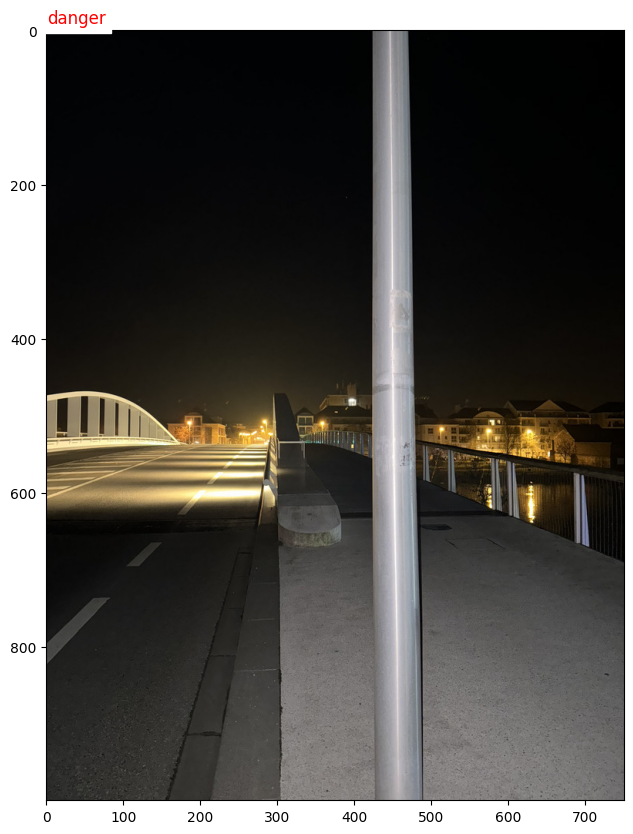

563 1000 /kaggle/input/sy32-dataset/dataset/val/images/0799.jpg


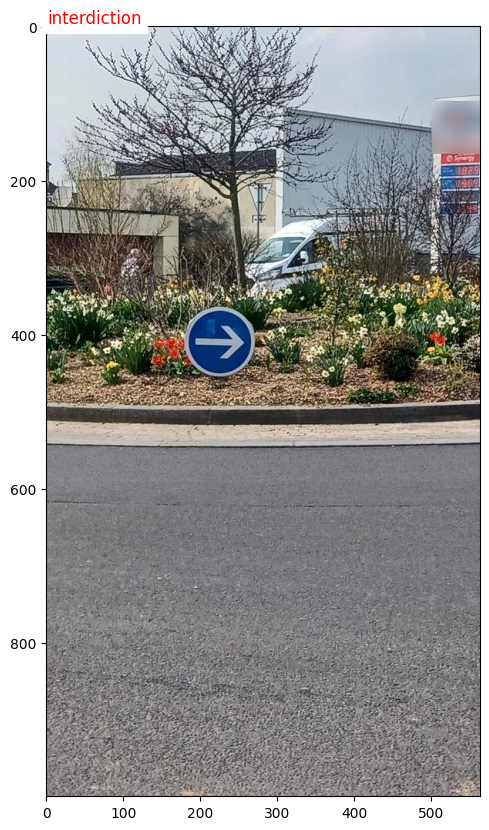

750 1000 /kaggle/input/sy32-dataset/dataset/val/images/0617.jpg


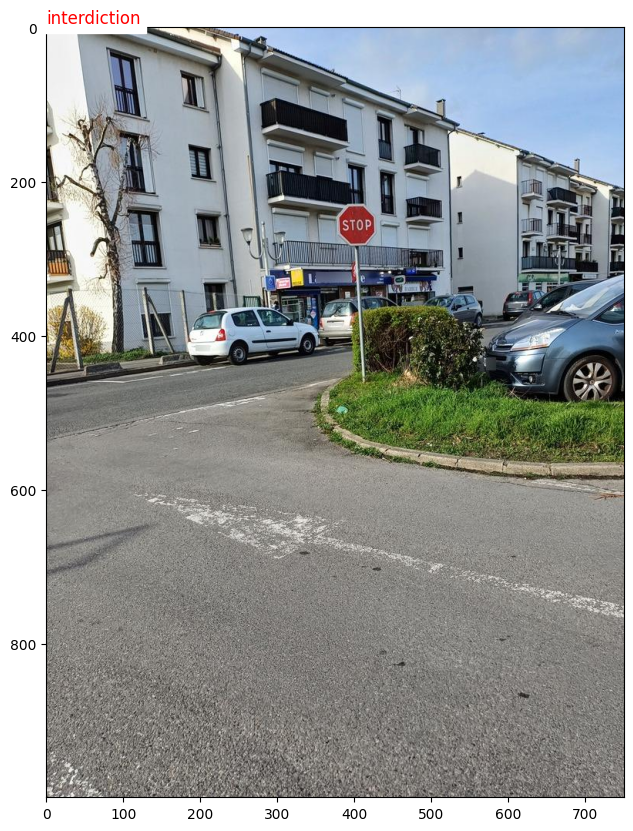

750 1000 /kaggle/input/sy32-dataset/dataset/val/images/0444.jpg


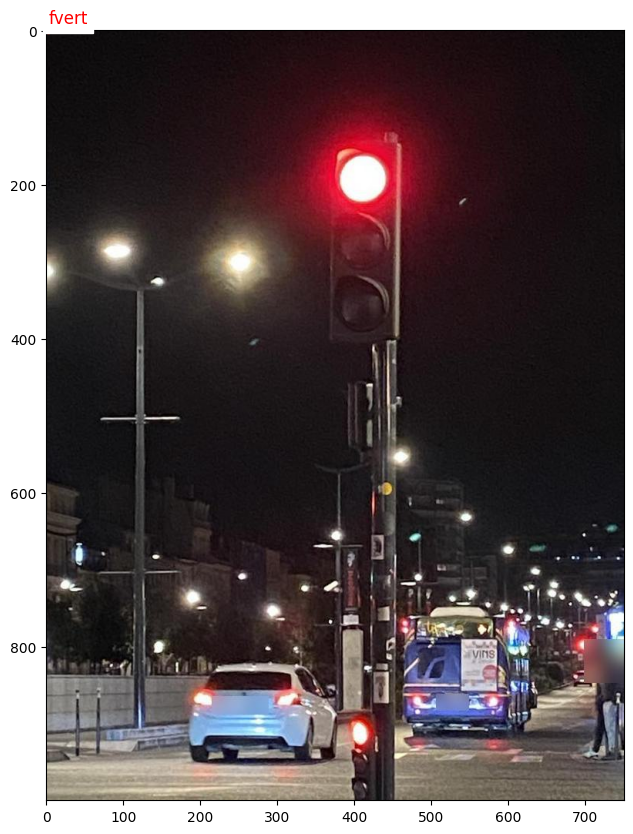

750 1000 /kaggle/input/sy32-dataset/dataset/val/images/0748.jpg


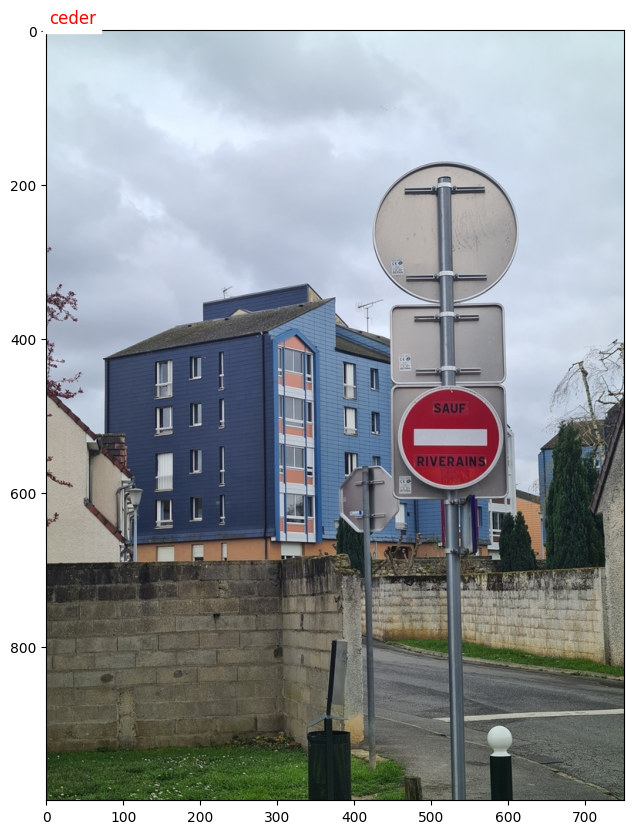

In [16]:
from PIL import Image
import skimage.io as io

val_img_folder = os.path.join('/kaggle', 'input', 'sy32-dataset', 'dataset', 'val', 'images')

def predict_image(image_path):
    '''Prédit le label et les boites pour une image'''
    
    # Charge et transforme l'image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Ajouter une dimension pour le batch
    image = image.to(device)
    
    regressor_op, classifier_op = model(image)
    
    # Convertir les résultats en CPU et en numpy pour les afficher ou les utiliser
    regressor_op = regressor_op.cpu().detach().numpy()
    classifier_op = classifier_op.cpu().detach().numpy()

    return regressor_op, classifier_op


labels_str = ['ceder', 'danger', 'frouge', 'forange', 'fvert', 'interdiction', 'obligation', 'stop']

for i, filename in enumerate(os.listdir(val_img_folder)):
    # affichage des 5 premières images
    if i > 4:
        break
    
    # Construire le chemin complet du fichier
    filepath = os.path.join(val_img_folder, filename)

    # Vérifier si c'est un fichier (et non un dossier)
    if os.path.isfile(filepath):
        filename_img = os.path.join(val_img_folder, filename)
        regressor_op, classifier_op = predict_image(filename_img)
        regressor_op, classifier_op = regressor_op[0], classifier_op[0]
        
        # lecture img
        img = io.imread(filename_img)
        original_width, original_height = img.shape[1], img.shape[0]
        print(original_width, original_height, filepath)
        
        # box
        x_min = regressor_op[0] * original_width / 224
        y_min = regressor_op[1] * original_height / 224
        x_max = regressor_op[2] * original_width / 224
        y_max = regressor_op[3] * original_height / 224
        
        # label
        label_index = np.argmax(classifier_op)
        label_str = labels_str[label_index]
        
        fig, ax = plt.subplots(figsize=(10, 10))  # Create a new figure and axis
        ax.imshow(img)  # Plot the image

        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', facecolor='none')
        ax.add_patch(rect)  # Add the rectangle patch to the axis

        ax.text(x_min, y_min - 10, label_str, color='red', fontsize=12, backgroundcolor='white')
        
        plt.savefig(f"img_{i}.jpg", dpi=400)         
        plt.show()  # Show the figure                

        
        